In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Nikhi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Nikhi\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
db = pymysql.connect(
    host='localhost',
    user='root',
    password='*************',
    database='Ecommerce'
)
cursor = db.cursor()

# 1. List all unique cities where customers are located.

In [3]:
query = """select distinct customer_city from customers"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [4]:
query = """select count(order_id) from ecommerce.orders where year(order_purchase_timestamp) = '2017'"""

cursor.execute(query)

data = cursor.fetchall()

data[0][0]

45101

# 3. Find the total sales per category.

In [5]:
query = """select round(sum(payment.payment_value),2) as total_sales,products.product_category from order_items join products on products.product_id = order_items.product_id join payment on order_items.order_id = payment.order_id  group by products.product_category"""

cursor.execute(query)

data = cursor.fetchall()

data

df = pd.DataFrame(data,columns=['Sales','Category'])
df.head()

,Sales,Category
0,506738.66,perfumery
1,1430176.39,Furniture Decoration
2,486882.05,telephony
3,1712553.67,bed table bath
4,852294.33,automotive


# 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """select (sum(case when payment_installments>=1 then 1 else 0 end)/count(*))*100 as purchased_on_instllmnts from payment"""

cursor.execute(query)

data = cursor.fetchall()

data[0][0]

Decimal('99.9981')

# 5. Count the number of customers from each state. 

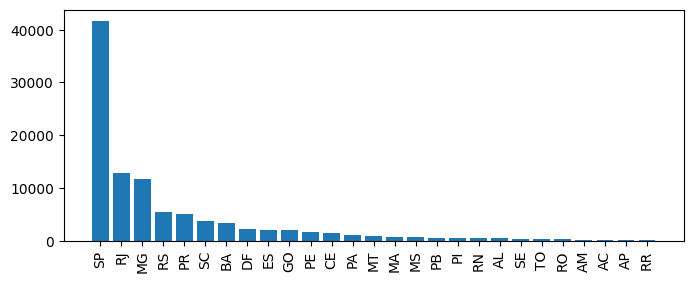

In [7]:
query = """select customer_state,count(customer_id) from customers group by customer_state"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['States','Cust_count'])
df = df.sort_values(by='Cust_count',ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df['States'],df['Cust_count'])
plt.xticks(rotation=90)
plt.show()

# 6. Calculate the number of orders per month in 2018.

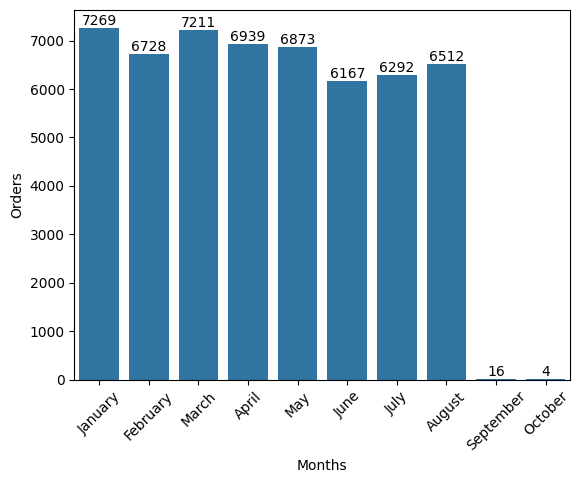

In [8]:
query = """select monthname(order_purchase_timestamp) as month_,count(order_id) as no_of_orders from orders where year(order_purchase_timestamp)=2018 group by month_ order by no_of_orders desc"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['Months','Orders'])
lis = ['January','February','March','April','May','June','July','August','September','October']
#plt.figure(figsize=(8,3.7))
ax = sns.barplot(x=df['Months'],y=df['Orders'],order=lis)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [9]:
query = """with count_per_orders as(select orders.customer_id, orders.order_id, count(order_items.order_id) as oc 
from order_items join orders on 
orders.order_id = order_items.order_id group by orders.customer_id, orders.order_id) 
select customers.customer_city, avg(count_per_orders.oc) as avg_countorder_per_prod 
from customers join count_per_orders on 
count_per_orders.customer_id = customers.customer_id 
group by customers.customer_city order by avg_countorder_per_prod desc"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['city','avg_countorder/prod'])
df.head()


,city,avg_countorder/prod
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,datas,6.0000
3,candido godoi,6.0000
4,matias olimpio,5.0000


# 8. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """select upper(products.product_category),
round(sum(payment.payment_value)/(select sum(payment_value) from payment)*100,2) as total_sales
from order_items join products on 
products.product_id = order_items.product_id 
join payment on order_items.order_id = payment.order_id  
group by products.product_category"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['Product_Cat','Sales%'])
df

,Product_Cat,Sales%
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,BED TABLE BATH,10.70
4,AUTOMOTIVE,5.32
...,...,...
69,CDS MUSIC DVDS,0.01
70,LA CUISINE,0.02
71,FASHION CHILDREN'S CLOTHING,0.00
72,PC GAMER,0.01


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [14]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price))
from products join order_items
on order_items.product_id = products.product_id
group by products.product_category"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['category','order_count','price'])
df.corr(numeric_only=True)

,order_count,price
order_count,1.00000,-0.10644
price,-0.10644,1.00000


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

([0, 1, 2, 3, 4],
 [Text(0, 0, '7c67e1448b00f6e969d365cea6b010ab'),
  Text(1, 0, '1025f0e2d44d7041d6cf58b6550e0bfa'),
  Text(2, 0, '4a3ca9315b744ce9f8e9374361493884'),
  Text(3, 0, '1f50f920176fa81dab994f9023523100'),
  Text(4, 0, '53243585a1d6dc2643021fd1853d8905')])

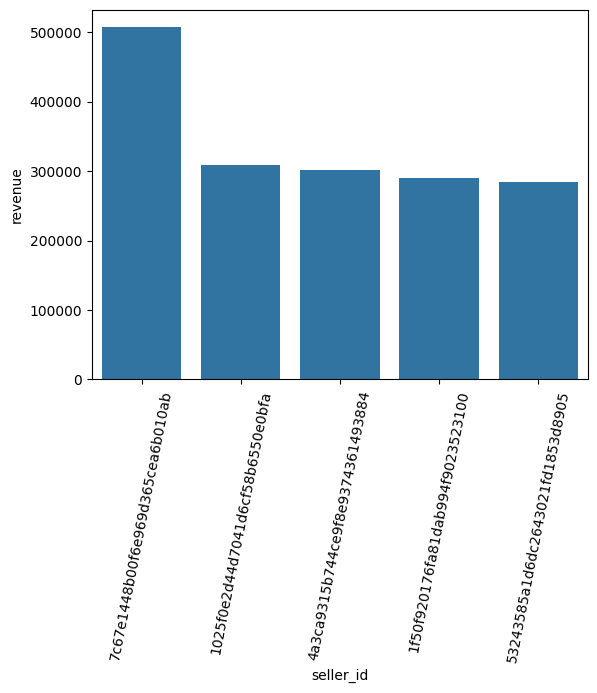

In [22]:
query = """select *, dense_rank() over(order by revenue desc) as rnk
from
(select seller.seller_id, round(sum(payment.payment_value),2) as revenue
from payment join order_items
on order_items.order_id = payment.order_id
join seller on 
order_items.seller_id = seller.seller_id
group by seller.seller_id) as a"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df = df.head()
sns.barplot(x=df['seller_id'],y=df['revenue'],data=df)
plt.xticks(rotation=79)

# 11. Calculate the moving average of order values for each customer over their order history.

<Axes: xlabel='time_stamp', ylabel='moving_avg'>

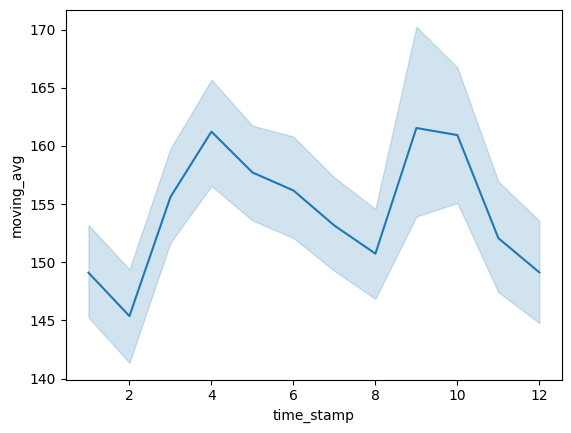

In [29]:
query = """select customer_id,month(order_purchase_timestamp),payment,
avg(payment) over(
partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row
) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp,
payment.payment_value as payment
from payment join orders
on orders.order_id = payment.order_id) as a"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['customer_id','time_stamp','payment','moving_avg'])
sns.lineplot(x='time_stamp', y='moving_avg', data=df)

# 12. Calculate the cumulative sales per month for each year.

In [30]:
query = """select years,months,payment,sum(payment) 
over(order by years,months) as cumlative_sales
from
(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months,
round(sum(payment.payment_value)) as payment from
payment join orders on orders.order_id = payment.order_id
group by years,months
order by years,months) as a"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['Year','Month','Payment','Cum_sales'])
df

,Year,Month,Payment,Cum_sales
0,2016,9,252.0,252.0
1,2016,10,59090.0,59342.0
2,2016,12,20.0,59362.0
3,2017,1,138488.0,197850.0
4,2017,2,291908.0,489758.0
5,2017,3,449864.0,939622.0
6,2017,4,417788.0,1357410.0
7,2017,5,592919.0,1950329.0
8,2017,6,511276.0,2461605.0
9,2017,7,592383.0,3053988.0


# 13. Calculate the year-over-year growth rate of total sales.

In [31]:
query = """select years, payment,((payment - lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 as sale_rates
from
(select year(orders.order_purchase_timestamp) as years,
round(sum(payment.payment_value)) as payment from
payment join orders on orders.order_id = payment.order_id
group by years
order by years) as a"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['Year','Revenue','YOY_Growth%'])
df

,Year,Revenue,YOY_Growth%
0,2016,59362.0,NaN
1,2017,7249747.0,12112.774165
2,2018,8699763.0,20.000919


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [32]:
query = """with a as(select customers.customer_id,min(orders.order_purchase_timestamp)as first_order
from customers join orders on customers.customer_id = orders.customer_id
group by customers.customer_id), 
b as
(select a.customer_id, count(distinct orders.order_purchase_timestamp)
from a join orders on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b on
a.customer_id = b.customer_id"""

cursor.execute(query)

data = cursor.fetchall()

data

((None,),)

# 15. Identify the top 3 customers who spent the most money in each year.

C:\Users\Nikhi\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Nikhi\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Nikhi\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


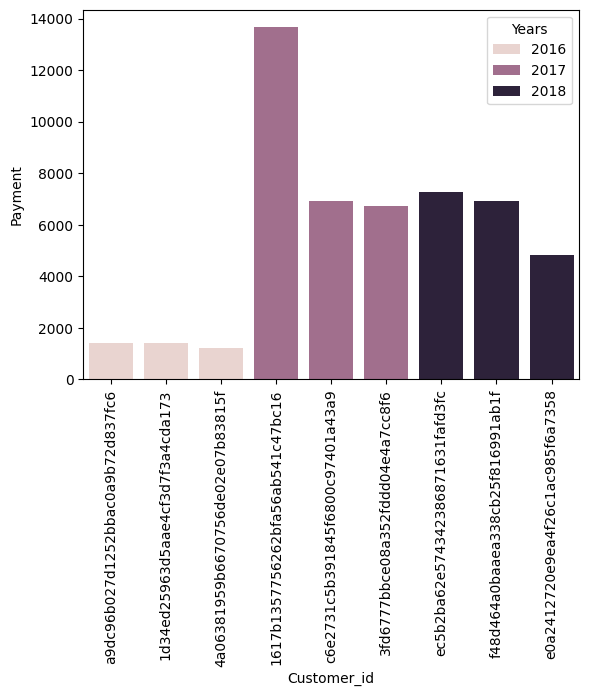

In [35]:
query = """select years, payments, customer_id, d_rank from
(select orders.customer_id,year(orders.order_purchase_timestamp)as years,sum(payment.payment_value)as payments,dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payment.payment_value) desc) as d_rank
from orders join payment on payment.order_id = orders.order_id
group by orders.customer_id,year(orders.order_purchase_timestamp)) as a
where d_rank <=3;
"""

cursor.execute(query)

data = cursor.fetchall()

data
df = pd.DataFrame(data,columns=['Years','Payment','Customer_id','Rank'])
sns.barplot(x = 'Customer_id', y = 'Payment', data = df, hue = 'Years')
plt.xticks(rotation=90)
plt.show()